# Introduction to Quant Finance

## Module 1.7: Kalman Filters 

### 1.7.2 Kalman Filters Examples

In this module we will look at some examples of using Kalman filters in practice. We'll also start using a library for computing the Kalman filter, as it provides a more robust option than our roll-your-own solution from the previous notebook. While using a library is no guarantee that the code will be bug free, many libraries have significant effort put into their development, giving us a better likelihood of them having fewer bugs than our own code.

Let's start with a straight-forward example, which is predicting stock prices with a Kalman filter. We are going to choose a stock with a long history and a seemingly stable price, and our theory is going to be that the stock is correctly valued and any major deviations will be corrected over time.


In [1]:
%run setup.ipy

In [2]:
# You'll need to install simdkalman for this notebook. Enter this into a new cell and run:

In [3]:
# !pip install simdkalman

In [4]:
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

stocks = quandl.get("WIKI/IBM")

stocks = stocks.asfreq('d')

close = stocks['Adj. Close']

close.index.inferred_freq

movement = close.pct_change().dropna()

fig = movement["2015":].plot()
fig.set_ylim(-0.1, 0.1)  # Note there are quite a few outliers, such as a 30% drop!

movement.mean()  # basically 0

movement = movement - movement.mean()  # Still, demean the data

In [374]:
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

# by Andrew D. Straw

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

NUM_PREDICTIONS = 31

# intial parameters
n_iter = len(movement)
sz = (n_iter + NUM_PREDICTIONS,) # size of array
x = movement.mean() # truth value (typo in example at top of p. 13 calls this z)
z = movement.values # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(n_iter)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = np.var(movement) # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = movement.mean()
P[0] = np.var(movement)

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]
    
    
predictions = np.zeros(NUM_PREDICTIONS)

predictions[0] = xhat[-1]
x_pred_range = [len(xhat)]

for k in range(NUM_PREDICTIONS):
    # time update
    predictions[k] = predictions[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    predictions[k] = xhatminus[k]+K[k]*(predictions[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

(20438, 20569)

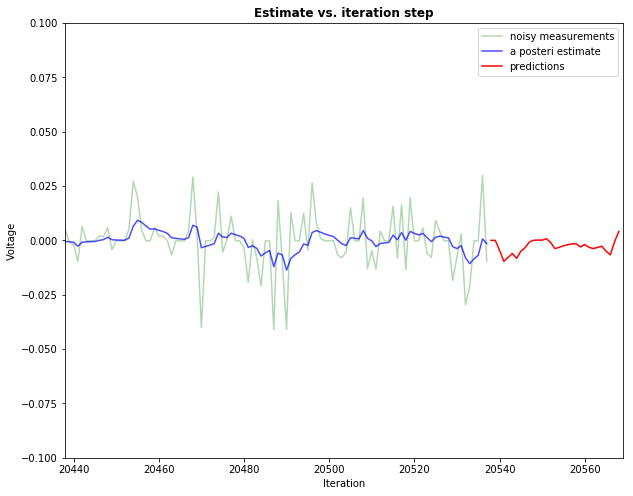

In [375]:
plt.figure()
plt.plot(z,'g-', alpha=0.3, label='noisy measurements')
plt.plot(xhat,'b-', alpha=0.7, label='a posteri estimate')

x_pred_range = np.arange(n_iter, n_iter + NUM_PREDICTIONS)
plt.plot(x_pred_range, predictions, 'r-', label='predictions')

plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.ylim([-0.1, 0.1])
plt.xlim([len(xhat)- 100, len(xhat) + NUM_PREDICTIONS])

[0, 0.01]

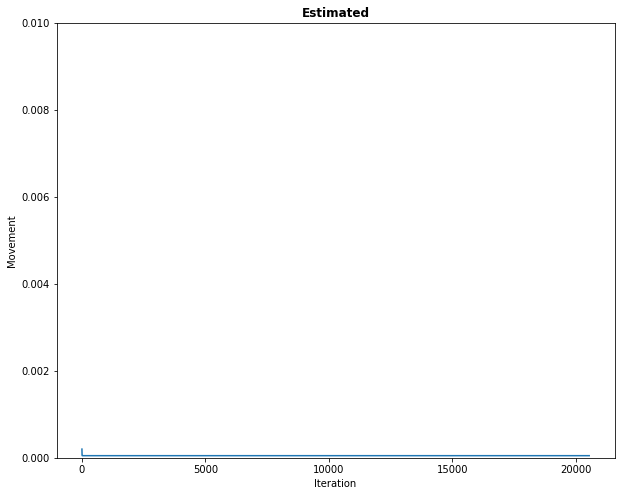

In [353]:
plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Movement')
plt.setp(plt.gca(),'ylim',[0,.01])